# Application of algorithms

### Import modules

In [1]:
import numpy as np
import random
from datetime import datetime
from datetime import timedelta
import pandas as pd
from statistics import mean
from loguru import logger
import uuid
import json
import pytz
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import itertools

### Read data

In [2]:
# global constants
filename = '20200715-E7S2WK4HFP-br.jsonl'

def parse_file(n_lines=None):
    with open(filename) as infile:
        if n_lines is not None: # only read at most n_lines
            file_iterator = itertools.islice(infile,n_lines,n_lines+500000)
        else:
            file_iterator = infile
        all_dict = list(map(json.loads,file_iterator))
        logger.info("Loaded {} rows",len(all_dict))
        return all_dict
    
def create_frame(br_object):
    deals = br_object['Bidrequest']['imp'][0]['pmp']['deals']
    for deal in deals:
        if deal['id'] == "E7S2WK4HFP":
            price = deal['bidfloor'] 
    record={
        'ts': br_object['Timestamp_status_receive_ms']/1000,
        'TZ': br_object['Timezone'],
        'imps': br_object['Imps'],
        'CPM': price,
        'Date': datetime.fromtimestamp(br_object['Timestamp_status_receive_ms']/1000)
        }
    record['price'] = (record['imps'] * record['CPM']) / 1000
    return record

In [3]:
# We have to load 6 000 000 lines
first = True
N_LINES = 0
while N_LINES < 5500000:
    if first:
        first = False
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = pd.DataFrame.from_records(records).sort_values("ts",ascending=True)
    else:
        N_LINES += 500000
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = df.append(pd.DataFrame.from_records(records).sort_values("ts",ascending=True))  

2020-07-21 11:23:46.260 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:24:02.711 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:24:21.147 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:24:36.839 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:24:54.688 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:25:13.491 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:25:33.036 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:25:50.398 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:26:07.192 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:26:26.908 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:26:47.083 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-21 11:27:09.440 | INFO     | __main__:parse_file:11 - Loaded 500000 rows


In [5]:
def win_proba(probability):
    return random.random() < probability
def delay_notif():
    if random.random() < 0.90:
        delay = random.randint(2,60)
    else:
        delay = random.randint(60,900)
    return delay

In [6]:
df['win'] = df.apply(lambda x: win_proba(0.95), axis = 1)
df['seconds_notif'] = df.apply(lambda x: delay_notif(), axis = 1)

### Hourly capping application

In [178]:
data_cap = df[df.TZ == 'America/New_York']
data_cap.set_index('Date', inplace=True)
data_cap.sort_index(inplace = True)

In [179]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.hourly_budget = self.daily_budget/ nb_hours_day
        # Impossible day and hour to initialize the setup
        self.day = 0
        self.current_hour = 0
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la BR
        day = datetime.fromtimestamp(ts).day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        hour = datetime.fromtimestamp(ts).hour
        # Changement of hour
        if hour != self.current_hour:
            self.current_hour = hour
            self.spent_hour = 0
        # If we begin a new day, we reset variables
        if self.day != day:
            self.remaining_budget = self.daily_budget
            self.engaged_budget = 0
            self.spent_budget = 0
        self.day = day
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        if self.hourly_budget >= self.spent_hour + price:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False

        return buying     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']
                self.spent_hour -= ev['br_price']

In [180]:
pacing = Algo(daily_budget=3000, nb_hours_day=24)

In [181]:
records = list()
pending_notifications = list()
day = 8
for current_ts, row in data_cap.iterrows():
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        records[-1]['engaged'] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        records[-1]['remaining'] = pacing.remaining_budget
        records[-1]['spent'] = pacing.spent_budget
        
    # Receive BR
    buying = pacing.buying_decision(row['ts'], row['price'])
    # Making a decision
    if buying:
        #Buying
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    record = {
        'buying':buying,
        'remaining':pacing.remaining_budget,
        'spent':pacing.spent_budget,
        'engaged':pacing.engaged_budget
    }
    records.append(record)
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
records[-1]['engaged'] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
records[-1]['remaining'] = pacing.remaining_budget
records[-1]['spent'] = pacing.spent_budget
pacing_df = pd.DataFrame.from_records(records)
new_df = pd.concat([data_cap.reset_index(),pacing_df], axis=1, ignore_index=True)
new_df.columns = ['Date','ts','TZ','imps','CPM','price','win','seconds_notif',
                 'buying','remaining','spent','engaged']
new_df.set_index('Date', inplace=True)

In [182]:
new_df.groupby(new_df.index.day).tail(1)

,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,engaged
Date,,,,,,,,,,,
2020-07-08 23:59:59.995,1.594246e+09,America/New_York,1.706032,9,0.015354,True,22,False,250.036079,2749.963921,-2.239172e-13
2020-07-09 23:59:59.835,1.594332e+09,America/New_York,2.805456,9,0.025249,True,9,False,0.031435,2999.968565,-2.405021e-14
2020-07-10 23:59:59.975,1.594418e+09,America/New_York,4.524550,9,0.040721,True,59,False,0.023648,2999.976352,-2.289666e-13
2020-07-11 23:59:59.873,1.594505e+09,America/New_York,6.357407,9,0.057217,True,56,False,0.034320,2999.965680,-5.919570e-14
2020-07-12 23:59:59.213,1.594591e+09,America/New_York,8.858175,9,0.079724,True,34,False,0.030912,2999.969088,1.284281e-13
2020-07-13 23:59:59.800,1.594678e+09,America/New_York,13.908466,9,0.125176,True,4,False,0.041432,2999.958568,1.450923e-14
2020-07-14 23:59:59.888,1.594764e+09,America/New_York,6.034709,9,0.054312,True,39,False,0.026733,2999.973267,-7.981810e-14
2020-07-15 05:10:10.558,1.594783e+09,America/New_York,10.327063,9,0.092944,True,21,False,2250.327213,749.672787,-1.177114e-13


In [183]:
day1 = new_df['2020-07-09 00:00:00':'2020-07-09 23:59:59']

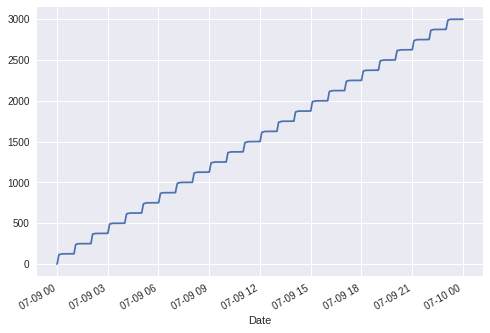

In [184]:
day1.spent.plot()

### Speed and acceleration application

In [128]:
data_sa = df[df.TZ == 'America/New_York']
data_sa.set_index('Date', inplace=True)
data_sa.sort_index(inplace = True)

In [141]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.target = daily_budget/(nb_hours_day*3600)
        # Impossible day to initialize the setup
        self.day = 0
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la br
        day = datetime.fromtimestamp(ts).day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        # If we begin a new day, we reset variables
        if self.day != day:
            self.remaining_budget = self.daily_budget
            self.BT = [self.target]
            self.acceleration = pd.Series(0, index=[datetime(year,month,day,6,0,0,0)])
            self.speed = pd.Series(0, index=[datetime(year,month,day,6,0,0,0)])
            self.engaged_budget = 0
            self.spent_budget = 0
        self.day = day
        # Remaining time before the end of the day
        end_day = datetime(year,month,day,19,40,0,0)
        remaining_time =  datetime.timestamp(end_day) - ts
        # Calculation of bt
        created_time_A = self.acceleration.index[-1] - timedelta(minutes=30)
        created_time_S = self.speed.index[-1] - timedelta(minutes=30)
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        alpha = 100 * (self.acceleration[self.acceleration.index > created_time_A].mean())
        try:
            bt = self.remaining_budget * ((1+alpha*self.speed[self.speed.index > created_time_S].mean()) / remaining_time) 
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        self.BT.append(bt)
        # Calculation of vt
        vt = self.BT[-1] - self.BT[-2] 
        self.speed[datetime.fromtimestamp(ts)] = vt
        at = self.speed[-1] - self.speed[-2]
        self.acceleration[datetime.fromtimestamp(ts)] = at
        if (bt >= self.target or bt<=0) and (self.remaining_budget - price) >= 0:
            buying = True
            self.engaged_budget += price
        else:
            buying = False

        return (buying, bt)     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']

In [146]:
pacing = Algo(daily_budget=3000, nb_hours_day=24)

In [147]:
records = list()
pending_notifications = list()
day = 8
counter = 0
for current_ts, row in data_sa.iterrows():
    counter += 1
    if counter == 10000:
        counter = 0
        print("treated 10000 rows")
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        records[-1]['engaged'] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        records[-1]['remaining'] = pacing.remaining_budget
        records[-1]['spent'] = pacing.spent_budget
    
    # Receive BR
    buying = pacing.buying_decision(row['ts'], row['price'])
    # Making a decision
    if buying:
        #Buying
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    record = {
        'buying':buying,
        'remaining':pacing.remaining_budget,
        'spent':pacing.spent_budget,
        'engaged':pacing.engaged_budget
    }
    records.append(record)
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
records[-1]['engaged'] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
records[-1]['remaining'] = pacing.remaining_budget
records[-1]['spent'] = pacing.spent_budget
pacing_df = pd.DataFrame.from_records(records)
new_df_sa = pd.concat([data_sa.reset_index(),pacing_df], axis=1, ignore_index=True)
new_df_sa.columns = ['Date','ts','TZ','imps','CPM','price','win','seconds_notif',
                 'buying','remaining','spent','engaged']
new_df_sa.set_index('Date', inplace=True)

treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows
treated 10000 rows


KeyboardInterrupt: 

In [ ]:
new_df_sa.groupby(new_df_sa.index.day).tail(1)

In [ ]:
day1_sa = new_df_sa['2020-07-09 00:00:00':'2020-07-09 23:59:59']

In [ ]:
day1_sa.spent.plot()

### Evolutive target application

In [206]:
data_et = df[df.TZ == 'America/New_York']
data_et.set_index('Date', inplace=True)
data_et.sort_index(inplace = True)

In [207]:
def gen_prop(br_object):
    temp = br_object.imps.groupby([br_object.index.date,br_object.index.weekday,br_object.index.hour]).sum()
    temp.index.names = ['date','weekday','hour']
    temp = temp.reset_index()
    temp = temp.imps.groupby([temp.weekday, temp.hour]).mean().reset_index()
    pattern = temp.pivot_table('imps', index = temp.hour, columns=temp.weekday)
    pattern.dropna(axis='columns', inplace=True)
    line, col = pattern.shape
    for i in range(col):
        pattern.iloc[:,i] = pattern.iloc[:,i]*100/pattern.iloc[:,i].sum()
    return pattern

In [208]:
prop = gen_prop(data_et)

In [209]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day, prop_table):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.prop_table = prop_table
        # Impossible day and hour to initialize the setup
        self.day = 0
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la BR
        weekday = datetime.fromtimestamp(ts).weekday()
        day = datetime.fromtimestamp(ts).day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        hour = datetime.fromtimestamp(ts).hour
        # If we begin a new day, we reset variables
        if self.day != day:
            self.current_hour = -1
            self.remaining_budget_hour = 0
            self.remaining_budget = self.daily_budget
            self.engaged_budget = 0
            self.spent_budget = 0
        self.day = day
        # Changement of hour
        while hour != self.current_hour:
            self.current_hour += 1 
            # Evolutive target
            self.budget_hour = (self.prop_table.iloc[self.current_hour, weekday]/100)*self.daily_budget + self.remaining_budget_hour
            self.target = self.budget_hour/3600
            self.spent_hour = 0
            self.remaining_budget_hour = self.budget_hour - self.spent_hour
        # Remaining time before the end of the hour
        end_hour = datetime(year,month,day,hour,59,59,999999)
        remaining_time =  datetime.timestamp(end_hour) - ts
        # Calculation of bt
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        try:
            bt = self.remaining_budget_hour * (1 / remaining_time) 
        except ZeroDivisionError:
            bt = 1
        if (bt >= self.target) and (self.remaining_budget - price) >= 0:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

        return buying     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']
                self.spent_hour -= ev['br_price']

In [210]:
pacing = Algo(daily_budget=3000, nb_hours_day=24, prop_table = prop)

In [211]:
records = list()
pending_notifications = list()
day = 8
for current_ts, row in data_et.iterrows():
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        records[-1]['engaged'] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        records[-1]['remaining'] = pacing.remaining_budget
        records[-1]['spent'] = pacing.spent_budget
        
    # Receive BR
    buying = pacing.buying_decision(row['ts'], row['price'])
    # Making a decision
    if buying:
        #Buying
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    record = {
        'buying':buying,
        'remaining':pacing.remaining_budget,
        'spent':pacing.spent_budget,
        'engaged':pacing.engaged_budget
    }
    records.append(record)
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
records[-1]['engaged'] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
records[-1]['remaining'] = pacing.remaining_budget
records[-1]['spent'] = pacing.spent_budget
pacing_df = pd.DataFrame.from_records(records)
new_df_et = pd.concat([data_et.reset_index(),pacing_df], axis=1, ignore_index=True)
new_df_et.columns = ['Date','ts','TZ','imps','CPM','price','win','seconds_notif',
                 'buying','remaining','spent','engaged']
new_df_et.set_index('Date', inplace=True)

In [212]:
new_df_et.groupby(new_df_et.index.day).tail(1)

,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,engaged
Date,,,,,,,,,,,
2020-07-08 23:59:59.995,1.594246e+09,America/New_York,1.706032,9,0.015354,True,22,False,0.007566,2997.183862,2.808572
2020-07-09 23:59:59.835,1.594332e+09,America/New_York,2.805456,9,0.025249,True,9,False,0.019264,2999.173836,0.806900
2020-07-10 23:59:59.975,1.594418e+09,America/New_York,4.524550,9,0.040721,True,59,False,0.022137,3001.365685,-1.387823
2020-07-11 23:59:59.873,1.594505e+09,America/New_York,6.357407,9,0.057217,True,56,False,0.023037,2999.192953,0.784010
2020-07-12 23:59:59.213,1.594591e+09,America/New_York,8.858175,9,0.079724,True,34,False,0.011325,3000.182183,-0.193508
2020-07-13 23:59:59.800,1.594678e+09,America/New_York,13.908466,9,0.125176,True,4,False,0.084277,2998.657177,1.258546
2020-07-14 23:59:59.888,1.594764e+09,America/New_York,6.034709,9,0.054312,True,39,True,0.000241,3000.967647,-0.967888
2020-07-15 05:10:10.558,1.594783e+09,America/New_York,10.327063,9,0.092944,True,21,False,2351.832830,651.275980,-3.108810


In [213]:
day1_et = new_df_et['2020-07-09 00:00:00':'2020-07-09 23:59:59']

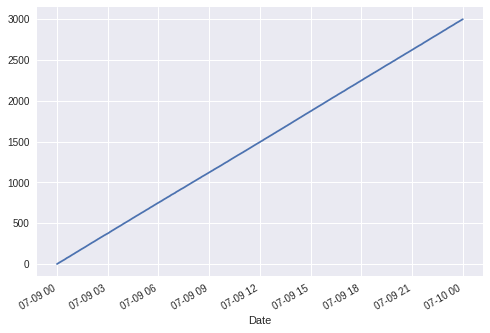

In [214]:
day1_et.spent.plot()

In [216]:
counter = 0
for current_ts, row in data_et.iterrows():
    counter += 1
    if counter == 100000:
        counter = 0
        print('iterated on 100000 rows')


iterated on 100000 rows
iterated on 100000 rows
iterated on 100000 rows


KeyboardInterrupt: 